In this notebook we design a multi-modal model using GraphSAGE.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.layers import Dense
from keras.models import Sequential
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchtext
import torch
from torch.nn import Linear
import itertools
import nltk
import spacy
import random
from tqdm import tqdm
import time
from IPython.display import Javascript
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
import random
import csv
import os
import sys

In [ ]:
random.seed(10)

In [ ]:
df = pd.read_csv('./datasets/gentrification_labels.csv')

In [ ]:
df.tail(10)

,GEOID,label,the_geom,STATEFP10,COUNTYFP10,TRACTCE10,NAME10,NAMELSAD10,INTPTLAT,INTPTLONG,long+,long-,lat+,lat-
791,17031843200,1,MULTIPOLYGON (((-87.65045099997508 41.85258499...,17,31,843200,8432.0,Census Tract 8432,41.848715,-87.664217,-87.660597,-87.667837,41.851420,41.846010
792,17031843300,1,MULTIPOLYGON (((-87.68821699998962 41.85933700...,17,31,843300,8433.0,Census Tract 8433,41.863764,-87.692550,-87.688930,-87.696170,41.866469,41.861059
793,17031843400,1,MULTIPOLYGON (((-87.72356499996559 41.85156999...,17,31,843400,8434.0,Census Tract 8434,41.849327,-87.732022,-87.728402,-87.735642,41.852032,41.846622
794,17031843500,1,MULTIPOLYGON (((-87.6927909999821 41.844721999...,17,31,843500,8435.0,Census Tract 8435,41.840983,-87.697566,-87.693946,-87.701186,41.843688,41.838278
795,17031843600,0,MULTIPOLYGON (((-87.61128600000754 41.80216899...,17,31,843600,8436.0,Census Tract 8436,41.806765,-87.608949,-87.605329,-87.612569,41.809470,41.804060
796,17031843700,0,MULTIPOLYGON (((-87.69666899996376 41.94854100...,17,31,843700,8437.0,Census Tract 8437,41.945560,-87.690034,-87.686414,-87.693654,41.948265,41.942855
797,17031843800,0,MULTIPOLYGON (((-87.6451599999826 41.794302000...,17,31,843800,8438.0,Census Tract 8438,41.801657,-87.640476,-87.636856,-87.644096,41.804362,41.798952
798,17031843900,0,MULTIPOLYGON (((-87.55868599996295 41.77379199...,17,31,843900,8439.0,Census Tract 8439,41.778993,-87.576130,-87.572510,-87.579750,41.781698,41.776288
799,17031980000,0,MULTIPOLYGON (((-87.92062799997296 42.00453199...,17,31,980000,9800.0,Census Tract 9800,41.979419,-87.902438,-87.898818,-87.906058,41.982124,41.976714
800,17031980100,0,MULTIPOLYGON (((-87.73789600001243 41.78578500...,17,31,980100,9801.0,Census Tract 9801,41.785981,-87.750900,-87.747280,-87.754520,41.788686,41.783276


In [ ]:
ids = df['TRACTCE10']
labels = df['label']
lats = df['INTPTLAT']
longs = df['INTPTLONG']

In [ ]:
econ_df = pd.read_csv('./datasets/df_original_econ.csv')

In [ ]:
object_df = pd.read_csv('./datasets/object_detection_2labels.csv')
object_df

,tract_id,house_num,shape_area,shape_length,shape_area_c,shape_length_c,target
0,832400,779.0,2.228243e+06,154689.910422,2.040189e+06,141230.226156,0
1,832500,177.0,1.712526e+06,65381.669831,1.571339e+06,59466.536988,0
2,832600,192.0,1.542560e+06,62029.187004,1.418126e+06,56437.295050,0
3,832900,116.0,9.165843e+05,39755.607375,8.440270e+05,36175.309647,0
4,833000,106.0,3.059690e+06,72289.006236,2.786114e+06,65925.252918,0
...,...,...,...,...,...,...,...
793,831900,447.0,1.317559e+06,101141.433622,1.194704e+06,91186.471272,0
794,832000,213.0,1.536429e+06,70739.019693,1.391498e+06,63580.085051,0
795,832100,218.0,1.805965e+06,77444.712979,1.621782e+06,69571.020570,0
796,832200,405.0,1.110235e+06,86114.732169,1.009572e+06,77541.209972,0


In [ ]:
image_df = pd.read_csv('./datasets/img_emb_16.csv', header=None)
image_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10501,1.187499,-1.159133,-1.149609,-1.511092,1.148012,1.233166,1.172413,1.173985,1.176566,1.106709,1.217907,1.185406,-1.280427,-1.207126,1.159843,-1.184841
1,10502,3.126476,-3.154806,-3.081431,-3.393782,3.117289,3.146034,3.171250,3.099674,3.093844,3.094124,3.070471,3.123192,-3.274757,-3.168600,3.115875,-3.158023
2,10702,5.476369,-5.495948,-5.521673,-5.841062,5.526231,5.529928,5.571685,5.453818,5.507252,5.468679,5.567666,5.463492,-5.717911,-5.547170,5.494441,-5.545836
3,20602,3.201371,-3.257612,-3.259790,-2.989403,3.164995,3.240377,3.218383,3.224705,3.245058,3.275841,3.256920,3.246516,-3.143377,-3.246902,3.236605,-3.246147
4,20901,0.387151,-0.434821,-0.434407,-0.400668,0.413244,0.441259,0.378637,0.432676,0.349975,0.360998,0.409983,0.328201,-0.471946,-0.394934,0.367366,-0.381234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,843100,2.706815,-2.705452,-2.704769,-2.674759,2.680752,2.663995,2.653602,2.709802,2.681530,2.719460,2.737297,2.682012,-2.539948,-2.709328,2.723066,-2.652754
794,843600,0.509147,-0.465967,-0.494204,-0.416152,0.535473,0.500779,0.531782,0.438141,0.463191,0.490766,0.510326,0.481009,-0.419967,-0.496489,0.464319,-0.511035
795,843700,0.677278,-0.672207,-0.678978,-0.565878,0.682993,0.698786,0.697133,0.662704,0.675585,0.651828,0.645108,0.679789,-0.666428,-0.644014,0.666011,-0.680978
796,843800,1.092929,-1.082171,-1.022227,-1.353202,1.037204,1.057261,1.069360,1.071691,1.032291,1.072736,1.087018,1.047585,-1.111611,-1.058116,1.047303,-1.090198


In [ ]:
combined_df = pd.merge(econ_df, object_df, left_on='TRACTCE10', right_on='tract_id')
combined_df = pd.merge(combined_df, image_df, left_on='tract_id', right_on=0)

In [ ]:
ids = combined_df['tract_id']
labels = combined_df['label']
lats = combined_df['INTPTLAT']
longs = combined_df['INTPTLONG']
econ_embedings = combined_df[['Total households', 'Median household income (dollars)',
                              'GROSS RENT Occupied units paying rent Median (dollars)',
                              'INTPTLAT', 'INTPTLONG']]
objects = combined_df[['house_num', 'shape_area']]
image_df = combined_df[list(range(1,17))]

In [ ]:
objects = objects.fillna(0)

In [ ]:
image_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.845741,-1.839947,-1.838605,-2.042803,1.825219,1.794558,1.791847,1.845882,1.773100,1.808467,1.823092,1.822765,-1.908576,-1.845630,1.814921,-1.842692
1,-2.883270,2.877886,2.871109,1.680214,-2.822166,-2.801896,-2.791914,-2.825832,-2.844652,-2.901969,-2.818703,-2.832392,2.330689,2.807811,-2.878302,2.788067
2,-3.227083,3.307095,3.267232,2.434837,-3.237657,-3.213023,-3.208734,-3.251623,-3.325904,-3.251636,-3.269793,-3.347070,2.913864,3.234600,-3.275483,3.202581
3,0.645561,-0.672235,-0.666934,-0.826195,0.642829,0.663228,0.622831,0.716879,0.629133,0.636953,0.667744,0.650324,-0.661005,-0.600184,0.686782,-0.685423
4,0.112293,-0.118052,-0.045969,-0.883121,0.111790,0.110669,0.119076,0.070072,0.089974,0.109943,0.121450,0.086153,-0.495834,-0.156854,0.100644,-0.139092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,1.403598,-1.378958,-1.419904,-1.649451,1.435124,1.402905,1.397952,1.349198,1.364665,1.390980,1.380734,1.402953,-1.441286,-1.476859,1.389614,-1.387461
794,0.509147,-0.465967,-0.494204,-0.416152,0.535473,0.500779,0.531782,0.438141,0.463191,0.490766,0.510326,0.481009,-0.419967,-0.496489,0.464319,-0.511035
795,0.677278,-0.672207,-0.678978,-0.565878,0.682993,0.698786,0.697133,0.662704,0.675585,0.651828,0.645108,0.679789,-0.666428,-0.644014,0.666011,-0.680978
796,1.092929,-1.082171,-1.022227,-1.353202,1.037204,1.057261,1.069360,1.071691,1.032291,1.072736,1.087018,1.047585,-1.111611,-1.058116,1.047303,-1.090198


In [ ]:
chi_lat_n = 42.05
chi_lat_s = 41.7
chi_long_w = -87.9
chi_long_e = -87.53

In [ ]:
tracts = pd.DataFrame(list(zip(ids, lats, longs, labels)))
tracts.columns = ['id', 'lat', 'long', 'label']

In [ ]:
tracts.describe()

,id,lat,long,label
count,798.000000,798.000000,798.000000,798.000000
mean,403945.775689,41.859612,-87.677231,0.197995
std,276995.736725,0.089995,0.058809,0.398738
min,10100.000000,41.650000,-87.910000,0.000000
25%,160825.000000,41.780000,-87.710000,0.000000
50%,351250.000000,41.870000,-87.670000,0.000000
75%,670275.000000,41.940000,-87.640000,0.000000
max,843900.000000,42.020000,-87.530000,1.000000


In [ ]:
tracts.tail(10)

,id,lat,long,label
788,843000,41.87,-87.72,0.0
789,843100,41.86,-87.70,0.0
790,843200,41.85,-87.66,1.0
791,843300,41.86,-87.69,1.0
792,843400,41.85,-87.73,1.0
793,843500,41.84,-87.70,1.0
794,843600,41.81,-87.61,0.0
795,843700,41.95,-87.69,0.0
796,843800,41.80,-87.64,0.0
797,843900,41.78,-87.58,0.0


In [ ]:
for index, row in tracts.iterrows():
    if (row['lat'] > chi_lat_n or row['lat'] < chi_lat_s or
            row['long'] > chi_long_e or row['long'] < chi_long_w):
        tracts = tracts.drop([index])

In [ ]:
pip install pykml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 135 kB/s 


In [ ]:
from pykml import parser

In [ ]:
h_lat_n = 42.05
h_lat_s = 41.7
h_long_w = -87.82
h_long_e = -87.53

In [ ]:
def get_distance(p1, p2):
    dist = math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    return dist

In [ ]:
filepath = './datasets/kmlHospitals.kml'
with open(filepath) as fobj:
    folder = parser.parse(fobj).getroot().Document.Folder

hospitals = []
for pm in folder.Placemark:
    coordinates = pm.Point.coordinates
    longitude = float(str(coordinates)[0:11])
    latitude = float(str(coordinates)[12:21])
    if ((latitude > h_lat_s and latitude < h_lat_n) and
            (longitude > h_long_w and longitude < h_long_e)):
        hospitals.append({"longitude": longitude, "latitude": latitude, "label":0, "closest": -1})

In [ ]:
for i, hospital in enumerate(hospitals):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (hospital["longitude"], hospital["latitude"]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
            closest_i = index
    hospitals[i]["label"] = int(label)
    hospitals[i]["closest"] = int(closest_i)

In [ ]:
filepath = './datasets/CTA_RailStations.kml'
with open(filepath) as fobj:
    folder = parser.parse(fobj).getroot().Document.Folder

cta = []
for pm in folder.Placemark:
    coordinates = str(pm.Point.coordinates).split(',')
    longitude = float(coordinates[0])
    latitude = float(coordinates[1])
    if ((latitude > h_lat_s and latitude < h_lat_n) and
            (longitude > h_long_w and longitude < h_long_e)):
        cta.append({"longitude": longitude, "latitude": latitude, "label":0, "closest": -1})

In [ ]:
for i, station in enumerate(cta):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (station["longitude"], station["latitude"]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
            closest_i = index
    cta[i]["label"] = int(label)
    cta[i]["closest"] = int(closest_i)

In [ ]:
filepath = './datasets/kmlPrivateSchools.kml'
with open(filepath) as fobj:
    folder = parser.parse(fobj).getroot().Document.Folder

private_schools = []
for pm in folder.Placemark:
    coordinates = pm.Point.coordinates
    longitude = float(str(coordinates)[0:11])
    latitude = float(str(coordinates)[12:21])
    if ((latitude > h_lat_s and latitude < h_lat_n) and
            (longitude > h_long_w and longitude < h_long_e)):
        private_schools.append({"longitude": longitude, "latitude": latitude, "label":0, "closest": -1})

In [ ]:
filepath = './datasets/kmlPublicSchools.kml'
with open(filepath) as fobj:
    folder = parser.parse(fobj).getroot().Document.Folder

public_schools = []
for pm in folder.Placemark:
    coordinates = pm.Point.coordinates
    longitude = float(str(coordinates)[0:11])
    latitude = float(str(coordinates)[12:21])
    if ((latitude > h_lat_s and latitude < h_lat_n) and
            (longitude > h_long_w and longitude < h_long_e)):
        public_schools.append({"longitude": longitude, "latitude": latitude, "label":0, "closest": -1})

In [ ]:
all_schools = public_schools + private_schools

In [ ]:
for i, school in enumerate(all_schools):
    closest_distance = 1000000
    for index, row in tracts.iterrows():
        dist = get_distance((row['long'], row['lat']),
                            (school["longitude"], school["latitude"]))
        if dist < closest_distance:
            closest_distance = dist
            label = row['label']
            closest_i = index
    all_schools[i]["label"] = int(label)
    all_schools[i]["closest"] = int(closest_i)

In [ ]:
tract_lats = tracts['lat'].tolist()
tract_longs = tracts['long'].tolist()
tract_labels = tracts['label'].tolist()

In [ ]:
tract_dicts = []
for i, vals in enumerate(list(zip(tract_longs, tract_lats, tract_labels))):
    t_dict = {"longitude": vals[0], "latitude": vals[1], "label":vals[2], "closest": i}
    tract_dicts.append(t_dict)

In [ ]:
all_nodes = tract_dicts + hospitals + cta + all_schools

In [ ]:
tract_indices = list(range(0, len(tracts)))
all_indices = list(range(0, len(all_nodes)))
hospital_indices = list(range(len(tracts), len(tracts) + len(hospitals)))
cta_indices = list(range(len(tracts) + len(hospitals), len(tracts) + len(hospitals) + len(cta)))
school_indices = list(range(len(tracts) + len(hospitals) + len(cta), len(tracts) + len(hospitals) + len(cta) + len(all_schools)))

In [ ]:
len(hospitals), len(hospital_indices)

(48, 48)

**Creating the graph using NetworkX**

In [ ]:
city_graph = nx.Graph()
color_map = []
# Create nodes
for i, node_dict in enumerate(all_nodes):
    city_graph.add_node(i,
                        pos=(node_dict["longitude"],
                             node_dict["latitude"])
                        )
    
    if node_dict["label"] == 1:
         color_map.append('purple')
    else:
        color_map.append('lightblue')

# Add hospital edges
for tract_i in all_indices:
    hospital_dict = {}
    for hospital_i in hospital_indices:
        hospital_dict[hospital_i] = get_distance((all_nodes[hospital_i]["longitude"], all_nodes[hospital_i]["latitude"]),
                                             (all_nodes[tract_i]["longitude"], all_nodes[tract_i]["latitude"]))
    
    closest2 = sorted(hospital_dict, key=hospital_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i]["latitude"]
        s_long = all_nodes[i]["longitude"]
        distance = get_distance((all_nodes[tract_i]["longitude"], all_nodes[tract_i]["latitude"]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

# Add school edges
for tract_i in all_indices:
    school_dict = {}
    for school_i in school_indices:
        school_dict[school_i] = get_distance((all_nodes[school_i]["longitude"], all_nodes[school_i]["latitude"]),
                                             (all_nodes[tract_i]["longitude"], all_nodes[tract_i]["latitude"]))
    
    closest2 = sorted(school_dict, key=school_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i]["latitude"]
        s_long = all_nodes[i]["longitude"]
        distance = get_distance((all_nodes[tract_i]["longitude"], all_nodes[tract_i]["latitude"]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

# Add subway edges
for tract_i in all_indices:
    cta_dict = {}
    for cta_i in cta_indices:
        cta_dict[cta_i] = get_distance((all_nodes[cta_i]["longitude"], all_nodes[cta_i]["latitude"]),
                                             (all_nodes[tract_i]["longitude"], all_nodes[tract_i]["latitude"]))
    
    closest2 = sorted(cta_dict, key=cta_dict.get, reverse=False)[0:2]
    
    for i in closest2:
        s_lat = all_nodes[i]["latitude"]
        s_long = all_nodes[i]["longitude"]
        distance = get_distance((all_nodes[tract_i]["longitude"], all_nodes[tract_i]["latitude"]),
                                (s_long, s_lat))
        city_graph.add_edge(tract_i, i, weight=distance)
        # city_graph.add_edge(tract_i, i)

In [ ]:
# Create a dictionary of node attributes
attrs = {}
for i, node_dict in enumerate(all_nodes):
    if i in school_indices:
        node_type = [1, 0, 0, 0]
    elif i in hospital_indices:
        note_type = [0, 1, 0, 0]
    elif i in cta_indices:
        node_type = [0, 0, 1, 0]
    else:
        node_type = [0, 0, 0, 1]

    closest_i = node_dict["closest"]

    attrs[i] = {"econ_0": econ_embedings['Total households'][closest_i],
                "econ_2": econ_embedings['Median household income (dollars)'][closest_i],
                "econ_3": econ_embedings['GROSS RENT Occupied units paying rent Median (dollars)'][closest_i],
                "econ_6": econ_embedings['INTPTLAT'][closest_i],
                "econ_7": econ_embedings['INTPTLONG'][closest_i],
                "area": objects["shape_area"][closest_i],
                "house_num": objects['house_num'][closest_i],
                "img_1": image_df[1][closest_i],
                "img_2": image_df[2][closest_i],
                "img_3": image_df[3][closest_i],
                "img_4": image_df[4][closest_i],
                "img_5": image_df[5][closest_i],
                "img_6": image_df[6][closest_i],
                "img_7": image_df[7][closest_i],
                "img_8": image_df[8][closest_i],
                "img_9": image_df[9][closest_i],
                "img_10": image_df[10][closest_i],
                "img_11": image_df[11][closest_i],
                "img_12": image_df[12][closest_i],
                "img_13": image_df[13][closest_i],
                "img_14": image_df[14][closest_i],
                "img_15": image_df[15][closest_i],
                "img_16": image_df[16][closest_i],
                "node_type_s": node_type[0],
                "node_type_h": node_type[1],
                "node_type_c": node_type[2],
                "node_type_t": node_type[3]
                }


nx.set_node_attributes(city_graph, attrs)

In [ ]:
pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 8.9 MB/s 


In [ ]:
import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import tensorflow as tf

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.isotonic import IsotonicRegression

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from stellargraph.calibration import TemperatureCalibration, IsotonicCalibration
from stellargraph.calibration import plot_reliability_diagram, expected_calibration_error

from stellargraph import datasets
from stellargraph import StellarGraph

In [ ]:
attrs_df = pd.DataFrame(attrs).T
attrs_df

,econ_0,econ_2,econ_3,econ_6,econ_7,area,house_num,img_1,img_2,img_3,...,img_11,img_12,img_13,img_14,img_15,img_16,node_type_s,node_type_h,node_type_c,node_type_t
0,2248.0,33750.0,865.0,42.02,-87.67,1.454984e+06,225.0,1.845741,-1.839947,-1.838605,...,1.823092,1.822765,-1.908576,-1.845630,1.814921,-1.842692,0.0,0.0,0.0,1.0
1,2670.0,40841.0,989.0,42.02,-87.68,1.895879e+06,455.0,-2.883270,2.877886,2.871109,...,-2.818703,-2.832392,2.330689,2.807811,-2.878302,2.788067,0.0,0.0,0.0,1.0
2,976.0,36563.0,943.0,42.02,-87.67,1.691946e+06,251.0,-3.227083,3.307095,3.267232,...,-3.269793,-3.347070,2.913864,3.234600,-3.275483,3.202581,0.0,0.0,0.0,1.0
3,2982.0,36870.0,948.0,42.02,-87.67,1.538231e+06,253.0,0.645561,-0.672235,-0.666934,...,0.667744,0.650324,-0.661005,-0.600184,0.686782,-0.685423,0.0,0.0,0.0,1.0
4,1870.0,39634.0,979.0,42.01,-87.66,7.446699e+05,93.0,0.112293,-0.118052,-0.045969,...,0.121450,0.086153,-0.495834,-0.156854,0.100644,-0.139092,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2264.0,58375.0,1359.0,41.94,-87.64,2.233858e+06,143.0,-6.254778,6.210947,6.261708,...,-6.255856,-6.313305,4.768279,6.156612,-6.211269,5.951921,1.0,0.0,0.0,0.0
2096,456.0,52969.0,1225.0,41.80,-87.74,2.203994e+06,881.0,0.688649,-0.724438,-0.718692,...,0.741801,0.712776,-0.649118,-0.748130,0.725887,-0.717139,1.0,0.0,0.0,0.0
2097,2304.0,32143.0,876.0,41.75,-87.61,1.552180e+06,616.0,-1.074803,1.060741,1.046222,...,-0.978452,-1.040797,0.941721,1.093895,-1.044336,1.042858,1.0,0.0,0.0,0.0
2098,1956.0,42667.0,821.0,41.74,-87.67,1.583828e+06,914.0,1.022407,-1.028579,-0.999371,...,0.995700,0.996925,-1.105426,-1.025002,0.981633,-1.040279,1.0,0.0,0.0,0.0


In [ ]:
scaler = StandardScaler()

In [ ]:
# Feed the graph into GraphSAGE
sg_city_graph = StellarGraph.from_networkx(city_graph,
                                           node_features=pd.DataFrame(scaler.fit_transform(attrs_df)))

In [ ]:
print(sg_city_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2100, Edges: 11785

 Node types:
  default: [2100]
    Features: float32 vector, length 27
    Edge types: default-default->default

 Edge types:
    default-default->default: [11785]
        Weights: range=[0, 0.132353], mean=0.0172083, std=0.0183388
        Features: none


In [ ]:
labels = [int(node["label"]) for node in all_nodes]
y = np.zeros([len(labels), 2])

for i, val in enumerate(labels):
    if val == 0:
        y[i][0] = 1
        y[i][1] = 0
    elif val == 1:
        y[i][0] = 0
        y[i][1] = 1
    else:
        print("ERROR")

In [ ]:
train_set, test_set = model_selection.train_test_split(
    pd.DataFrame(y), train_size=0.7, test_size=None, stratify=pd.DataFrame(y)
)
val_set = test_set

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_set)
val_targets = target_encoding.fit_transform(val_set)
test_targets = target_encoding.transform(test_set)

In [ ]:
batch_size = 150
dim_shape = [32, 4, 2]
epochs = 300

In [ ]:
generator = GraphSAGENodeGenerator(sg_city_graph, batch_size, dim_shape)

In [ ]:
train_gen = generator.flow(train_set.index, train_targets)

In [ ]:
graphsage_model = GraphSAGE(
    layer_sizes=dim_shape, generator=generator, bias=True
)

In [ ]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_set.index, val_targets)
test_gen = generator.flow(test_set.index, test_targets)

In [ ]:
history = model.fit(
    train_gen, epochs=epochs, validation_data=val_gen, shuffle=True,
)

Epoch 1/300
10/10 [==============================] - 10s 856ms/step - loss: 0.8045 - acc: 0.4571 - val_loss: 0.6342 - val_acc: 0.7524
Epoch 2/300
10/10 [==============================] - 7s 761ms/step - loss: 0.5643 - acc: 0.7986 - val_loss: 0.5097 - val_acc: 0.8079
Epoch 3/300
10/10 [==============================] - 7s 749ms/step - loss: 0.5028 - acc: 0.8082 - val_loss: 0.4980 - val_acc: 0.8079
Epoch 4/300
10/10 [==============================] - 7s 759ms/step - loss: 0.4955 - acc: 0.8082 - val_loss: 0.4936 - val_acc: 0.8079
Epoch 5/300
10/10 [==============================] - 7s 745ms/step - loss: 0.4919 - acc: 0.8082 - val_loss: 0.4904 - val_acc: 0.8079
Epoch 6/300
10/10 [==============================] - 7s 751ms/step - loss: 0.4885 - acc: 0.8082 - val_loss: 0.4863 - val_acc: 0.8079
Epoch 7/300
10/10 [==============================] - 7s 760ms/step - loss: 0.4842 - acc: 0.8082 - val_loss: 0.4808 - val_acc: 0.8079
Epoch 8/300
10/10 [==============================] - 7s 749ms/step -

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 2s 404ms/step - loss: 0.3205 - acc: 0.8937

Test Set Metrics:
	loss: 0.3205
	acc: 0.8937


In [ ]:
all_gen = generator.flow(list(city_graph.nodes), y)

all_predictions = model.predict(all_gen).squeeze()[..., np.newaxis]

all_predictions_df = pd.DataFrame(all_predictions[:,0], index=list(list(city_graph.nodes)))

test_preds = all_predictions_df.loc[test_set.index, :]

In [ ]:
test_predictions = test_preds.values
test_predictions_class = ((test_predictions > 0.5) * 1).flatten()
test_df = pd.DataFrame(
    {
        "Predicted_score": test_predictions.flatten(),
        "Predicted_class": test_predictions_class,
        "True": test_targets[:, 0],
    }
)

roc_auc = roc_auc_score(test_df["True"].values, test_df["Predicted_score"].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.9386091672214194


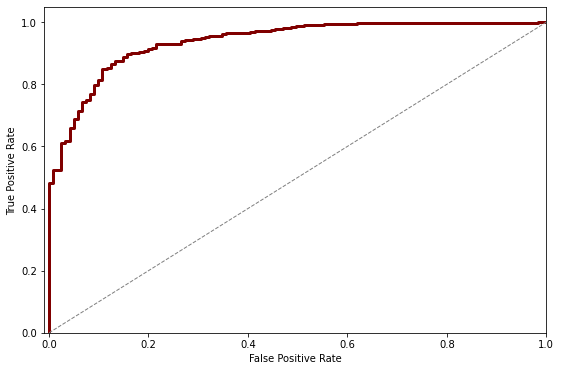

In [ ]:
fpr, tpr, thresholds = roc_curve(
    test_df["True"], test_df["Predicted_score"], pos_label=1
)
plt.figure(figsize=(9, 6,))

plt.plot(
    fpr, tpr, color="maroon", lw=3,
)
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
attrs_df.describe()

,econ_0,econ_2,econ_3,econ_6,econ_7,area,house_num,img_1,img_2,img_3,...,img_11,img_12,img_13,img_14,img_15,img_16,node_type_s,node_type_h,node_type_c,node_type_t
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2.100000e+03,2100.000000,2100.000000,2100.000000,2100.000000,...,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.0,2100.000000,2100.000000
mean,1391.937143,54002.972857,1018.533333,41.862795,-87.687195,1.544699e+06,556.917619,-0.038954,0.040343,0.044447,...,-0.040982,-0.047264,-0.014615,0.036894,-0.039317,0.026732,0.544286,0.0,0.065238,0.390476
std,857.844523,29829.179098,318.542242,0.088842,0.061884,6.443754e+05,369.799356,2.588874,2.582940,2.588124,...,2.588463,2.586285,2.462031,2.576952,2.584491,2.561078,0.498154,0.0,0.247004,0.487973
min,122.000000,0.000000,0.000000,41.650000,-87.910000,0.000000e+00,0.000000,-13.440310,-8.341751,-8.303929,...,-13.377987,-13.322714,-8.620275,-8.332081,-13.390610,-8.444178,0.000000,0.0,0.000000,0.000000
25%,802.500000,31917.750000,823.000000,41.780000,-87.730000,1.172051e+06,231.000000,-1.144412,-1.268938,-1.257270,...,-1.126261,-1.137014,-1.269026,-1.293615,-1.134124,-1.265931,0.000000,0.0,0.000000,0.000000
50%,1251.500000,45156.000000,963.000000,41.870000,-87.680000,1.541670e+06,514.000000,0.144916,-0.123413,-0.123123,...,0.125961,0.143239,-0.141785,-0.134005,0.154306,-0.133068,1.000000,0.0,0.000000,0.000000
75%,1773.750000,72297.750000,1128.000000,41.940000,-87.647500,1.918065e+06,855.000000,1.284991,1.103943,1.135810,...,1.268412,1.285854,1.022366,1.114484,1.285846,1.110914,1.000000,0.0,0.000000,1.000000
max,11012.000000,160833.000000,2895.000000,42.020000,-87.530000,5.068800e+06,1546.000000,8.356990,13.394217,13.349246,...,8.321366,8.349174,13.268136,13.422947,8.347641,13.387858,1.000000,0.0,1.000000,1.000000


In [ ]:
attrs_df.isnull().any()

econ_0         False
econ_2         False
econ_3         False
econ_6         False
econ_7         False
area           False
house_num      False
img_1          False
img_2          False
img_3          False
img_4          False
img_5          False
img_6          False
img_7          False
img_8          False
img_9          False
img_10         False
img_11         False
img_12         False
img_13         False
img_14         False
img_15         False
img_16         False
node_type_s    False
node_type_h    False
node_type_c    False
node_type_t    False
dtype: bool

**Analyze tabular and image embeddings only**

In [ ]:
X_data = attrs_df.astype(float).to_numpy()
y_data = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.3, 
                                                    random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
X_train_tensor = torch.tensor(X_train_std)
y_train_tensor = torch.tensor(y_train).type(torch.LongTensor)
X_test_tensor = torch.tensor(X_test_std)
y_test_tensor = torch.tensor(y_test).type(torch.LongTensor)


In [ ]:
model = Sequential()
model.add(Dense(8, input_dim=attrs_df.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit(tf.convert_to_tensor(X_train_std), y_train, epochs=50, batch_size=50)

Epoch 1/50
30/30 [==============================] - 0s 3ms/step - loss: 0.4288 - accuracy: 0.8156
Epoch 2/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3944 - accuracy: 0.8156
Epoch 3/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3790 - accuracy: 0.8156
Epoch 4/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3749 - accuracy: 0.8429
Epoch 5/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3639 - accuracy: 0.8558
Epoch 6/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3586 - accuracy: 0.8463
Epoch 7/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3559 - accuracy: 0.8633
Epoch 8/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3472 - accuracy: 0.8660
Epoch 9/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3416 - accuracy: 0.8687
Epoch 10/50
30/30 [==============================] - 0s 3ms/step - loss: 0.3401 - accuracy: 0.8721
Epoch 11/50
30/30 [

In [ ]:
_, accuracy = model.evaluate(X_test_std, y_test)
print('Accuracy: %.2f' % (accuracy*100))

20/20 [==============================] - 0s 2ms/step - loss: 0.3887 - accuracy: 0.8444
Accuracy: 84.44


In [ ]:
preds = model.predict(X_test_std)

In [ ]:
obj_cnn_dict = {}
mlp_labels = []
for i, node_dict in enumerate(tract_dicts):

    closest_i = node_dict["closest"]
    mlp_labels.append(node_dict['label'])


    obj_cnn_dict[i] = {
                "area": objects["shape_area"][closest_i],
                "house_num": objects['house_num'][closest_i]
                }

In [ ]:
obj_cnn_df = pd.DataFrame(scaler.fit_transform(pd.DataFrame(pd.DataFrame(obj_cnn_dict).T)))
obj_cnn_df

,0,1
0,-0.083061,-0.873369
1,0.614607,-0.236438
2,0.291906,-0.801368
3,0.048668,-0.795830
4,-1.207056,-1.238912
...,...,...
767,0.577409,0.403261
768,0.710586,1.325426
769,-2.340765,-1.488146
770,0.176573,-0.463518


In [ ]:
tracts['label']

0      1.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
793    1.0
794    0.0
795    0.0
796    0.0
797    0.0
Name: label, Length: 772, dtype: float64

In [ ]:
X_data = obj_cnn_df.astype(float).to_numpy()
y_data = np.array(mlp_labels)
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.2, 
                                                    random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
X_train_tensor = torch.tensor(X_train_std)
y_train_tensor = torch.tensor(y_train).type(torch.LongTensor)
X_test_tensor = torch.tensor(X_test_std)
y_test_tensor = torch.tensor(y_test).type(torch.LongTensor)


In [ ]:
model = Sequential()
model.add(Dense(8, input_dim=obj_cnn_df.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit(tf.convert_to_tensor(X_train_std), y_train, epochs=50, batch_size=50)

Epoch 1/50
13/13 [==============================] - 0s 3ms/step - loss: 0.6392 - accuracy: 0.6856
Epoch 2/50
13/13 [==============================] - 0s 3ms/step - loss: 0.5310 - accuracy: 0.7990
Epoch 3/50
13/13 [==============================] - 0s 3ms/step - loss: 0.5010 - accuracy: 0.7990
Epoch 4/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4966 - accuracy: 0.7990
Epoch 5/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4944 - accuracy: 0.7990
Epoch 6/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4927 - accuracy: 0.7990
Epoch 7/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4919 - accuracy: 0.7990
Epoch 8/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4912 - accuracy: 0.7990
Epoch 9/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4903 - accuracy: 0.7990
Epoch 10/50
13/13 [==============================] - 0s 3ms/step - loss: 0.4915 - accuracy: 0.7990
Epoch 11/50
13/13 [

In [ ]:
_, accuracy = model.evaluate(X_test_std, y_test)
print('Accuracy: %.2f' % (accuracy*100))

5/5 [==============================] - 0s 3ms/step - loss: 0.4884 - accuracy: 0.8000
Accuracy: 80.00
